In [156]:
import math
import random
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

pp = pprint.PrettyPrinter(indent=4)

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5, 0.25)

In [7]:
ys = f(xs)

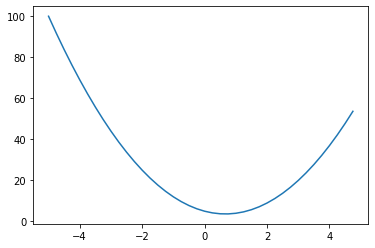

In [8]:
plt.plot(xs, ys)

In [9]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [10]:
# let's get more complex

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [12]:
# step size (testing the derivative w.r.t the input 'a')
step_size = 0.0001

# first sample
d1 = a*b + c

# Step one of our variables
# a += step_size # to get our derivative w.r.t. `a`
# b += step_size # to get our derivative w.r.t. `b`
c += step_size # to get our derivative w.r.t. `c`

# second sample
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)  

d1 4.0
d2 4.0001
slope 99999.99999976694


In [201]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        
        self.label = label
        self.data = data
        self.grad = 0.0
        
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value({self.label}, data={self.data}, grad={self.grad})"
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __add__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # print(f'    Calling _backward() (+) on {self}')
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # print(f'    Calling _backward() (*) on {self}')
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        
        assert isinstance(other, (int, float)), "Called __pow__ with non-int/float argument!"
        
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            # power rule combined with chain rule
            self.grad += other * self.data**(other - 1) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
     
    def tanh(self):

        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # print(f'    Calling _backward() on {self}')
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # d/dx(e^x) = e^x
        
        out._backward = _backward
        
        return out
    
    def backward(self):
    
        def topological_sort(v):

            ordering = []
            visited = set()

            def grow_topological(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        grow_topological(child)
                    ordering.append(v)    

            grow_topological(v)

            return ordering
    
        self.grad = 1.0

        topo = topological_sort(self)
        
        for v in reversed(topo):
            # print(f'Calling _backward() on {v}')
            v._backward()

# a.__add__(b)
# a + b

# a.__mul__(b)
# a * b

# d = (a.__mul__(b)).__add__(c)
# d.label = 'd'

# d.data
# d._prev
# d._op

# L = d * f
#
# (f(x+h) - f(x) / h
# ((d+h) * f - d * f) / h
# (df + hf - df) / h
# hf / h
# f
# 
# dL/dd = f
# dL/df = d

def inline_grad():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    
    L = d * f; L.label = 'L'; L.grad = 1.0
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    
    L = d * f; L.label = 'L'
    L2 = L.data + h
    
    print((L2 - L1) / h)
    
inline_grad()

0.9999999999976694


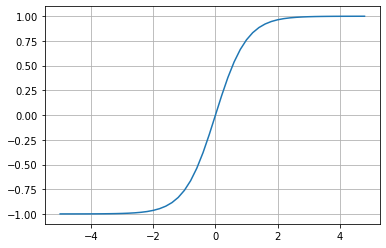

In [14]:
# tanh() sigmoid function
plt.plot(
    np.arange(-5,5,0.2),
    np.tanh(np.arange(-5,5,0.2))
)

plt.grid()

In [44]:
# neuron - conceptual model

# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# neuron bias
# b = Value(6.7, label='b')
# b = Value(8.0, label='b')
b = Value(6.88137358, label='b')

# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'

# x1 * w1 + x2 * w2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
# x1 * w1 + x2 * w2 + b
n = x1w1x2w2 + b; n.label = 'n'

# output (with activation function)
o = n.tanh(); o.label = 'o'

print(f'o={o}')

# backpropagation cycle

# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2

o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad =  n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad
# w1.grad
# x2.grad
# w2.grad

# automating the backprop step

# for v in topo:
#     print(f'Value(data={v.data}, grad={v.grad})')

o=Value(o, data=0.707106777676776, grad=0.0)


-1.5000000148906993

In [46]:
# backprop bug - example 1

a = Value(3.0, label='a')
b = a + a; b.label = 'b'

print(a)
print(b)

b.backward()

pp.pprint([a, b]) # Problem: 'a' should have 'grad' of 2.0 (not 1.0)

Value(a, data=3.0, grad=0.0)
Value(b, data=6.0, grad=0.0)
[Value(a, data=3.0, grad=2.0), Value(b, data=6.0, grad=1.0)]


In [76]:
# backprop bug - example 2

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

# d.backward()
# e.backward()
f.backward()

pp.pprint([a, b, d, e, f])

Calling _backward() on Value(f, data=-6.0, grad=1.0)
Calling _backward() on Value(e, data=1.0, grad=-6.0)
Calling _backward() on Value(d, data=-6.0, grad=1.0)
Calling _backward() on Value(b, data=3.0, grad=-8.0)
Calling _backward() on Value(a, data=-2.0, grad=-3.0)
[   Value(a, data=-2.0, grad=-3.0),
    Value(b, data=3.0, grad=-8.0),
    Value(d, data=-6.0, grad=1.0),
    Value(e, data=1.0, grad=-6.0),
    Value(f, data=-6.0, grad=1.0)]


In [85]:
# Supporting `Value` as a box type (i.e., auto-cast to `Value`)
a = Value(4.0)
b = a + 1.0; b.label = 'b'
b

Value(b, data=5.0, grad=0.0)

In [98]:
# Implementing e^x

a = Value(2.0, label='a')
b = a.exp(); b.label = 'b'

b.backward()

pp.pprint([a,b])

Calling _backward() on Value(b, data=7.38905609893065, grad=1.0)
Calling _backward() on Value(a, data=2.0, grad=7.38905609893065)
[   Value(a, data=2.0, grad=7.38905609893065),
    Value(b, data=7.38905609893065, grad=1.0)]


In [121]:
# Implementing division

# a / b
# a * (1/b)
# a * (b^-1)

# Redefine division in terms of exponentiation to a negative power

# Implementing __pow__

a = Value(2.0, label='a')
b = a ** 3.0; b.label = 'b'
# b.backward()
# b

# Implementing __neg__

a = Value(2.0, label='a')
b = -a; b.label = 'b'
# b.backward()
# b

# Implementing __sub__

a = Value(2.0, label='a')
b = a - 3.0; b.label = 'b'
# b.backward()
# b

# Implementing __realdiv__

a = Value(2.0, label='a')
b = a / 3.0; b.label = 'b'
b.backward()
b

Calling _backward() on Value(b, data=0.6666666666666666, grad=1.0)
Calling _backward() on Value(a, data=2.0, grad=0.3333333333333333)
Calling _backward() on Value(, data=0.3333333333333333, grad=2.0)


Value(b, data=0.6666666666666666, grad=1.0)

In [125]:
# Manual expansion of tanh()

# tanh(x) = (e^2x - 1) / (e^2x + 1)

x = Value(5.0, label='x')
two_x = x * 2.0
e2x = two_x.exp()
e2x_minus_one = e2x - 1
e2x_plus_one = e2x + 1
n = e2x_minus_one / e2x_plus_one

n

Value(, data=0.9999092042625952, grad=0.0)

In [129]:
# Aside: Constructing an expression tree with PyTorch

In [133]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double();
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [136]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [140]:
print(torch.Tensor([2.0]).dtype)
print(torch.Tensor([2.0]).double().dtype)

torch.float32
torch.float64


In [142]:
o.item()

0.7071066904050358

In [144]:
o.data.item()

0.7071066904050358

In [150]:
x1.grad.item()

-1.5000003851533106

In [221]:
# Constructing a neural net (built upon our expression graphs)

class Neuron:
    
    def __init__(self, num_inputs):
        
        # Note that our __init__ doesn't offer args for
        # weight or bias
        
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]

        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):

        # self.w * x + self.b
        
        # Supports an arbitrary-length vector as the neuron's input
        
        # Note that we can pass our neuron's bias as the `start` arg for sum()
        
        # activation = sum(w_i * x_i for w_i, x_i in zip(self.w, x)) + self.b
        activation = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        
        # Using tanh() as our simple activation function for the neuron
        
        output = activation.tanh()
        
        return output
    
    def parameters(self):
        return self.w + [self.b]

In [222]:
# Create a 2-input neuron
n = Neuron(2)

# Pass a sample input to our neuron, storing the output
o = n([2.0, 3.0])

In [246]:
# Grouping multiple neurons into a single layer

class Layer:
    
    def __init__(self, num_inputs, num_outputs):
        
        # Each output will exist as a single neuron, which takes
        # `num_inputs` inputs;
        
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
        
    def __call__(self, x):
        
        # Calling our neurons with a vector input yields a vector output
        # of the same dimension; we'll convert unary vectors to scalars
        
        outputs = [n(x) for n in self.neurons]
        
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [328]:
# Create a layer with 3 2-input neurons
L = Layer(2, 3)

# Pass sample inputs into our layer, storing the outputs of its neurons
L([2.0, 3.0])

[Value(, data=0.6404309974042753, grad=0.0),
 Value(, data=-0.7931884211635079, grad=0.0),
 Value(, data=-0.9829488861068082, grad=0.0)]

In [355]:
# Combining multiple layers into a multi-layer perceptron (MLP)

class MLP:
    
    def __init__(self, num_inputs, num_outputs):
        
        # Layers appear in sequence, meaning that one layer's output count
        # is equivalent to the next layer's input count; any two neighboring
        # values in `num_outputs` tells us the shape of a corresponding layer
        #
        # Based on this, we can calculate the total number of neurons in
        # our perceptron:
        # 
        #   The first layer (i=0) receives `num_inputs` inputs and
        #   yields `num_outputs[0]` outputs
        # 
        #   The i-th layer (i>0) receives `num_outputs[i-1]` inputs and
        #   yields `num_outputs[i]` outputs
        #
        # We can generalize this by combining `num_inputs` and `num_outputs`
        # into a single addressable lookup list:
        
        sizes = [num_inputs] + num_outputs
        
        lookup = range(len(num_outputs))
        
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in lookup]
        
    def __call__(self, x):
        
        # `x` contains a `num_inputs`-size input vector; we will pass `x`
        # through each of our percetron's layers, mutating it with each pass
        
        for layer in self.layers:
            x = layer(x)
            
        # Return the final result (output)
            
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [451]:
P = MLP(3, [4, 4, 1])

P([2.0, 3.0, -1.0])

Value(, data=-0.024465972508511676, grad=0.0)

In [268]:
# Convenience methods - collecting parameters of our instances

# pp.pprint(n.parameters())

# pp.pprint(L.parameters())

# pp.pprint(P.parameters())

In [452]:
# Producing some predictions from our (untrained) MLP

# We'll pass each of these sample inputs to our perceptron

# 1. FORWARD PASS (no batching)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Each sample input has one desired output that we want our MLP to predict

ys = [1.0, -1.0, -1.0, 1.0] # desired predictions

In [434]:
# Below, `y_predicted` contains 1 prediction (value) for each input in `xs` 

y_predicted = [P(x) for x in xs]

In [435]:
# Calculating a single loss value from our outputs, using mean-squared error

# Each value in `y_predicted` corresponds to a certain input in `xs`, so
# we can pair them together and aggregate from there by calculating the MSE

# 2. RECALCULATE LOSS

loss = sum([(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, y_predicted)])
loss

Value(, data=0.010921190190459305, grad=0.0)

In [436]:
# 3. BACKPROPAGATE OUR GRADIENTS

loss.backward()

In [437]:
# Manually adjusting the parameters of our perceptron to lower the loss

# 4. STEP IN THE OPPOSITE DIRECTION OF OUR GRADIENT

learning_rate = 0.1

for p in P.parameters():
    
    # Note that `p.grad` is essentially a vector pointing in a direction that
    # would maximize the (local) loss function; we're looking to minimize the
    # loss (locally), so our step must occur in the opposite direction;
    
    p.data += -learning_rate * p.grad


In [439]:
# P.layers[0].neurons[0].w[0].grad
# P.layers[0].neurons[0].w[0].data

# 5. CHECK OUR PREDICTIONS

y_predicted

[Value(, data=0.9954147248514116, grad=-0.009170550297176838),
 Value(, data=-0.9029302449394205, grad=0.19413951012115893),
 Value(, data=-0.9618723370641932, grad=0.07625532587161366),
 Value(, data=0.9951102746699172, grad=-0.009779450660165612)]

In [453]:
# Writing out the training loop

training_cycles = 20
learning_rate = 0.1

for i in range(training_cycles):

    # forward pass
    y_predicted = [P(x) for x in xs]

    # recalculate loss
    loss = sum([(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, y_predicted)])

    # backward pass
    
    # COMMON BUG: Forgetting to zero-out your gradients before
    # running the next backward pass
    
    for p in P.parameters():
        p.grad = 0
    
    loss.backward()

    # gradient updates
    for p in P.parameters():
        p.data += -learning_rate * p.grad
        
    # print current loss
    print(f'i={i}: loss={loss}')


i=0: loss=Value(, data=5.688251884733565, grad=1.0)
i=1: loss=Value(, data=3.445688461356, grad=1.0)
i=2: loss=Value(, data=3.132410739492249, grad=1.0)
i=3: loss=Value(, data=4.5444802681713465, grad=1.0)
i=4: loss=Value(, data=4.520146449394031, grad=1.0)
i=5: loss=Value(, data=2.6368183575498714, grad=1.0)
i=6: loss=Value(, data=1.6168820674570625, grad=1.0)
i=7: loss=Value(, data=0.311245924838963, grad=1.0)
i=8: loss=Value(, data=0.13387625665554292, grad=1.0)
i=9: loss=Value(, data=0.10587913540437861, grad=1.0)
i=10: loss=Value(, data=0.08920937422491769, grad=1.0)
i=11: loss=Value(, data=0.07746361105516852, grad=1.0)
i=12: loss=Value(, data=0.06854403735436906, grad=1.0)
i=13: loss=Value(, data=0.061475399638620025, grad=1.0)
i=14: loss=Value(, data=0.055712543446103074, grad=1.0)
i=15: loss=Value(, data=0.05091569492395, grad=1.0)
i=16: loss=Value(, data=0.046857756651258894, grad=1.0)
i=17: loss=Value(, data=0.0433794217409787, grad=1.0)
i=18: loss=Value(, data=0.04036488312